In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.io.wavfile, scipy.fft, scipy.signal

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def gaussian(sigma = 1):
    tail = 3 * int(sigma)
    x = np.arange(-tail, tail + 1)
    return np.exp(-(x/sigma)**2 / 2) / (sigma * np.sqrt(2 * np.pi))

In [3]:
def smooth(data, smoothness = 32):
    return scipy.signal.convolve(data, gaussian(sigma = smoothness), mode = 'same')

In [4]:
def sharpen(data, filter_size = 2, threshold = 0.1):
    s_filter = np.full(2 * filter_size + 1, -1 / filter_size)
    s_filter[filter_size] = 1
    sharp = np.copy(data)
    sharp[scipy.signal.convolve(data, s_filter, mode = 'same') < threshold] = 0
    return sharp

In [5]:
def condense(data, window_size):
    padded = np.pad(data, (0, (window_size - len(data) % window_size) % window_size))
    reshaped = padded.reshape((-1, window_size))
    return reshaped.max(axis = 1), reshaped.argmax(axis = 1) + np.arange(0, len(data), window_size)

In [6]:
def normalize(data):
    return data / np.max(data)

In [7]:
def splits(data, threshold = 5000, condense_window = 2205):
    data = np.abs(data)
    condensed, peaks = condense(data, condense_window)
    for i in range(1, len(condensed) - 1):
        if (condensed[i-1] < condensed[i] > condensed[i+1] and
            condensed[i] > threshold):
            yield peaks[i]

In [8]:
def merge_peaks(peaks, merge_window = 4410):
    prev = -merge_window
    for p in peaks:
        if p >= prev + merge_window:
            yield p
        prev = p

In [9]:
def fourier_transform(data, sample_rate, cutoff_freq = 1000):
    fourier = scipy.fft.fft(data)
    freqs = scipy.fft.fftfreq(len(data), d = 1 / sample_rate)
    return fourier[:cutoff_freq], freqs[:cutoff_freq]

In [10]:
def freq_upperbound(freqs, ft, ignore_threshold = 100):
    prev = 0
    ub = 22050
    for i in range(len(ft)):
        if ft[i] > 0 and freqs[i] - freqs[prev] > ignore_threshold:
            ub = min(ub, freqs[i] - freqs[prev])
            prev = i
    return ub

In [11]:
def octave_correction(references, ft, freqs, note):
    this_freq = freq_upperbound(freqs, ft)
    diff = [np.abs(freq_upperbound(freqs, references[i]) - this_freq) 
            for i in range(note % 12, len(references), 12)]
    return note % 12 + np.argmin(diff) * 12

In [125]:
def get_note(references, magnitudes, freqs, ft):
    projected = np.dot(references, ft) / magnitudes
    note = np.argmax(projected)
    if projected[note] == 0: return -1;
    return octave_correction(references, ft, freqs, note)

In [99]:
def get_principal_note(ref_fts, ref_mags, this):
    projected = np.dot(ref_fts, this) / ref_mags
    principal_note = np.argmax(projected)
    principal_freq = np.argmax(ref_fts[principal_note])
    coefficient = this[principal_freq] / ref_fts[principal_note][principal_freq]
    if coefficient == 0:
        return -1, 0, None
    return principal_note, projected[principal_note], this - coefficient * ref_fts[principal_note]

`condense()` attempts to capture the peaks of the signal and smooth out smaller oscillations (to mimic how the signal appears in a graph, e.g. in Voice Memos).

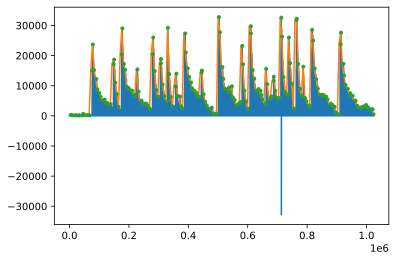

In [84]:
sample_rate, data = scipy.io.wavfile.read('yamaha/bean.wav')
data = np.abs(data)
c, i = condense(data, 5500)
plt.plot(data)
plt.plot(np.arange(0, len(data), 5500), c)
plt.plot(i, data[i], '.');

`splits()` first picks out peaks from the condensed version of the signal, and then `merge_peaks()` gets rid of peaks that are too close together.

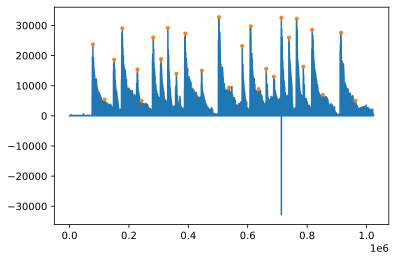

In [85]:
plt.plot(data)
markers = [s for s in merge_peaks(splits(data, condense_window = 5500), merge_window = 10000)]
plt.plot(markers, data[markers], '.');

"Learn" the transforms of each note by averaging their sharpened versions.

In [92]:
ref_fts = []
sample_duration = 5000
n = 1
for f, thresh in [('med.wav', 5000)]:
    sample_rate, data = scipy.io.wavfile.read('yamaha/' + f)
    onsets = [s for s in merge_peaks(splits(data, threshold = thresh, condense_window = 5500), merge_window = 10000)]
    notes = [fourier_transform(data[o:o+sample_duration], sample_rate, 1200) for o in onsets]
    for j, (ft, freqs) in enumerate(notes):
        s = sharpen(normalize(np.abs(ft))) # sharpen?
        if j >= len(ref_fts):
            ref_fts.append(np.zeros(len(freqs)))
        ref_fts[j] += s / n
ref_mags = np.sum(np.square(ref_fts), axis = 1)

134.40000000000003


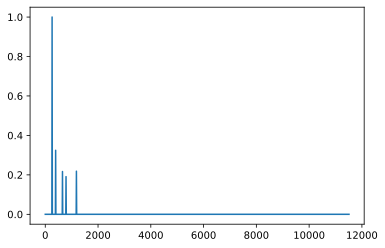

In [93]:
plt.plot(freqs, ref_fts[0])
print(freq_upperbound(freqs, ref_fts[0]))

In [183]:
sample_rate, data = scipy.io.wavfile.read('yamaha/LvB_fugue_theme.wav')
onsets = [s for s in merge_peaks(splits(data, condense_window = 5500), merge_window = 10000)]
# onsets = list(range(0, len(data), sample_duration))
notes = [fourier_transform(data[o:o+sample_duration], sample_rate, 1200)[0] for o in onsets]

In [206]:
mapping = 'C D♭ D E♭ E F G♭ G A♭ A B♭ B'.split()
note_colors = '''#ffb8b8 #ffc8b8 #ffdcb8 #fff1b8 #fffdb8 #dcffb8 #b8ffc0
                 #b8f8ff #b8e1ff #b8cdff #b8baff #e7b8ff #ffb8e0'''.split()

Taking the dot product of each possible note with the input note (projecting the input onto each of these vectors) to find the most similar one.

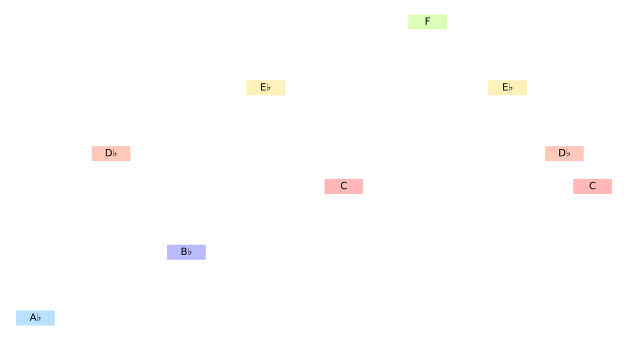

In [185]:
fig = plt.figure(figsize = (len(data) // 44100, len(ref_fts) // 12 * 3))
plt.axis('off')
for i in range(len(notes)):
    this = sharpen(normalize(np.abs(notes[i])))
    note = get_note(ref_fts, ref_mags, freqs, this)
    if note != -1:
        plt.scatter(onsets[i], note, s = 1500, marker = '_', color = note_colors[note % 12], linewidth = 15)
        plt.annotate(mapping[note % 12], (onsets[i] - 10, note), va = 'center', ha = 'center')

In [205]:
slices = [1] * 12
wp = {'width': 0.3}
inactive = ['#ededed'] * 12

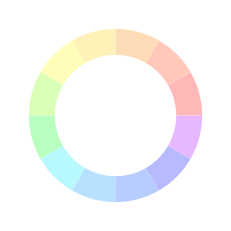

In [22]:
plt.pie(slices, wedgeprops = wp, colors = note_colors);

In [209]:
sample_rate, data = scipy.io.wavfile.read('yamaha/bean.wav')
onsets = [s for s in merge_peaks(splits(data, condense_window = 5500), merge_window = 10000)]
notes = [fourier_transform(data[o:o+sample_duration], sample_rate, 1200)[0] for o in onsets]

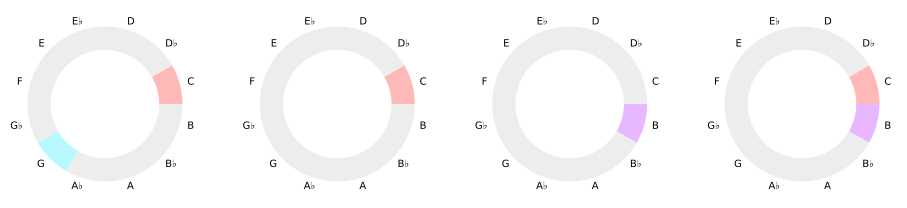

In [211]:
fig = plt.figure(figsize = (16, 64))
for i in range(4):
    this = sharpen(normalize(np.abs(notes[i])))
    principal, component, remainder = get_principal_note(ref_fts, ref_mags, this)
    palette = inactive[:]
    while component > 0.2:
        palette[principal % 12] = note_colors[principal % 12]
        principal, component, remainder = get_principal_note(ref_fts, ref_mags, remainder)
    fig.add_subplot(1, 4, i+1).pie(slices, wedgeprops = wp, labels = mapping, colors = palette)